# Dengue Outbreak Detection Using Autoencoder

In [161]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler


In [162]:
df = pd.read_csv('dengue-2013-2023.csv')

print(df.head())

  Disease  Year PROVINCE  Week_no  Count
0  Dengue  2013  Bangkok        1    351
1  Dengue  2013  Bangkok        2    399
2  Dengue  2013  Bangkok        3    300
3  Dengue  2013  Bangkok        4    280
4  Dengue  2013  Bangkok        5    262


### Preprocessing

In [163]:
# Only keep relevant columns
df = df[['Year', 'PROVINCE', 'Week_no', 'Count']]

In [164]:
# Count all cases by province
df_province = df.groupby('PROVINCE')['Count'].sum().reset_index()

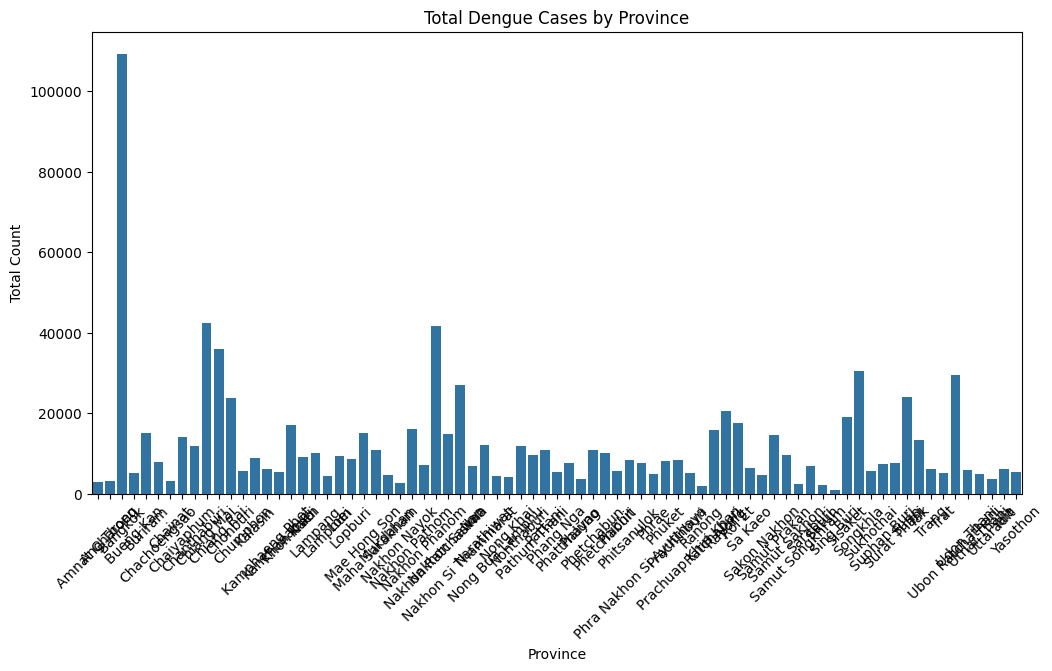

In [165]:
# OPTIONAL: plot the graph
plt.figure(figsize=(12, 6))
sns.barplot(data=df_province, x='PROVINCE', y='Count')
plt.title('Total Dengue Cases by Province')
plt.xlabel('Province')
plt.ylabel('Total Count')
plt.xticks(rotation=45)
plt.show()

In [166]:
# Print the most affected province
most_affected_province = df_province.loc[df_province['Count'].idxmax()]
print(f"Most affected province: {most_affected_province['PROVINCE']} with {most_affected_province['Count']} cases.")

Most affected province: Bangkok with 109244 cases.


In [167]:
# Filter a specific province
province = 'Bangkok'
df = df[df['PROVINCE'] == province]

# Drop the 'PROVINCE' column
df = df.drop(columns=['PROVINCE'])

In [168]:
# Sort by year and week
df = df.sort_values(by=['Year', 'Week_no']).reset_index(drop=True)

In [169]:
print(df.head())
print(df.describe())
print(df.info())

   Year  Week_no  Count
0  2013        1    351
1  2013        2    399
2  2013        3    300
3  2013        4    280
4  2013        5    262
              Year     Week_no        Count
count   563.000000  563.000000   563.000000
mean   2017.891652   26.193606   194.039076
std       3.118191   14.941279   231.782521
min    2013.000000    1.000000     0.000000
25%    2015.000000   13.000000    61.500000
50%    2018.000000   26.000000   135.000000
75%    2021.000000   39.000000   250.500000
max    2023.000000   53.000000  2166.000000
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 563 entries, 0 to 562
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype
---  ------   --------------  -----
 0   Year     563 non-null    int64
 1   Week_no  563 non-null    int64
 2   Count    563 non-null    int64
dtypes: int64(3)
memory usage: 13.3 KB
None


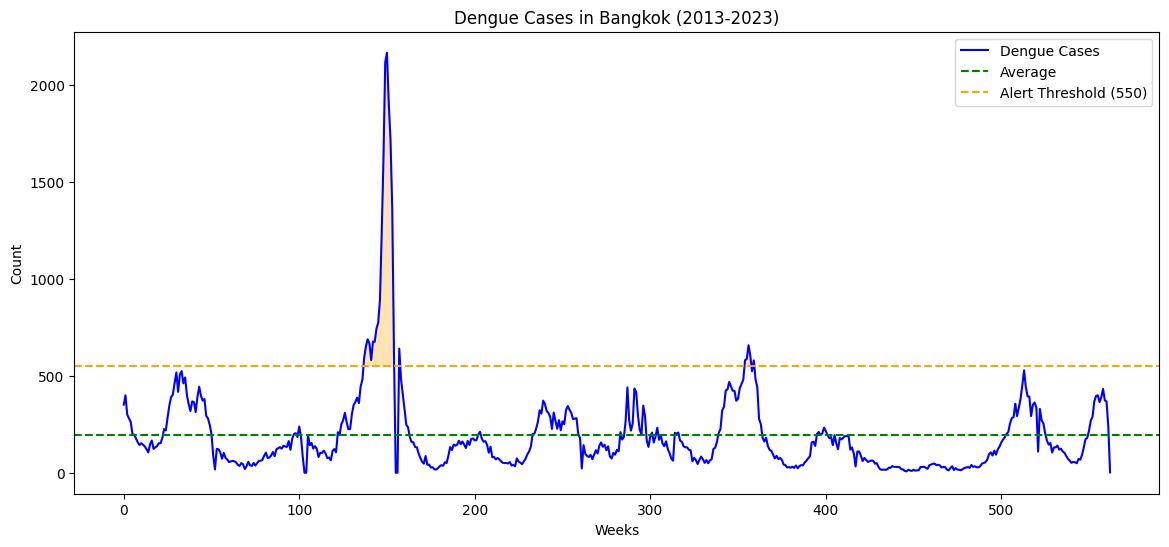

In [170]:
# Quick Visualization and add a red line for average case
plt.figure(figsize=(14,6))
plt.plot(df['Count'].values, label='Dengue Cases', color='blue')
plt.axhline(y=df['Count'].mean(), color='g', linestyle='--', label='Average')
# Add alert threshold
alert_threshold = 550
plt.axhline(y=alert_threshold, color='orange', linestyle='--', label=f'Alert Threshold ({alert_threshold})')
# Optional: Fill the area above the alert threshold
plt.fill_between(range(len(df)), alert_threshold, df['Count'].values, where=(df['Count'].values > alert_threshold), color='orange', alpha=0.3)
min_year, max_year = df['Year'].min(), df['Year'].max()
plt.title(f'Dengue Cases in {province} ({min_year}-{max_year})')
plt.xlabel('Weeks')
plt.ylabel('Count')
plt.legend()
plt.show()

In [171]:
# 5. Prepare Data for LSTM Autoencoder
scaler = MinMaxScaler()
count_scaled = scaler.fit_transform(df[['Count']])

In [172]:
# Create sequences
def create_sequences(data, time_steps=8):
    sequences = []
    for i in range(len(data) - time_steps):
        sequences.append(data[i:i+time_steps])
    return np.array(sequences)

In [173]:
import tensorflow as tf

# Configure TensorFlow to use only the CPU
tf.config.set_visible_devices([], 'GPU')

In [174]:
TIME_STEPS = 4

In [175]:
X = create_sequences(count_scaled, TIME_STEPS)

print(f"Shape of input sequences: {X.shape}")
print(X[0])
print(X[1])
print(X[2])

print(f"First 2 sequences of data of first column:")
for i in range(2):
    print(X[i].flatten())
    print(X[i].flatten()[0])

Shape of input sequences: (559, 4, 1)
[[0.16204986]
 [0.18421053]
 [0.13850416]
 [0.12927054]]
[[0.18421053]
 [0.13850416]
 [0.12927054]
 [0.1209603 ]]
[[0.13850416]
 [0.12927054]
 [0.1209603 ]
 [0.09141274]]
First 2 sequences of data of first column:
[0.16204986 0.18421053 0.13850416 0.12927054]
0.16204986149584488
[0.18421053 0.13850416 0.12927054 0.1209603 ]
0.18421052631578946


### Data Splitting 
We split data for training set **ONLY THE NORMAL CASES**, and testing set contains **OUTBREAK CASES**.

In [176]:
test_size = int(len(X) * 0.2)
print(f"20% of the data: {test_size}")

started_test_index = 100
# We take the testing dataset from index 100 to 220 
X_test = X[started_test_index:started_test_index+test_size]
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)
print(f"Shape of test sequences: {X_test.shape}")

X_train = np.concatenate((X[:started_test_index], X[started_test_index+test_size:]), axis=0)
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
print(f"Shape of train sequences: {X_train.shape}")

20% of the data: 111
Shape of test sequences: (111, 4, 1)
Shape of train sequences: (448, 4, 1)


In [177]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, RepeatVector

# 6. Build LSTM Autoencoder
def build_model(input_shape):
    inputs = Input(shape=input_shape)
    encoded = LSTM(64, activation='relu')(inputs)
    decoded = RepeatVector(input_shape[0])(encoded)
    decoded = LSTM(64, activation='relu', return_sequences=True)(decoded)
    decoded = LSTM(1, activation='sigmoid', return_sequences=True)(decoded)
    
    autoencoder = Model(inputs, decoded)
    autoencoder.compile(optimizer='adam', loss='mse')
    return autoencoder


In [178]:
model = build_model((TIME_STEPS, 1))
model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 4, 1)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_6 (LSTM)                   │ (None, 64)             │        16,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ repeat_vector_2 (RepeatVector)  │ (None, 4, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_7 (LSTM)                   │ (None, 4, 64)          │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_8 (LSTM)                   │ (None, 4, 1)           │           264 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 50,184 (196.03 KB)

 Trainable params: 50,184 (196.03 KB)

 Non-trainable params: 0 (0.00 B)

In [179]:
# 7. Train the Model
history = model.fit(
    X_train, X_train,
    epochs=50,
    batch_size=64,
    validation_split=0.1,
    shuffle=False
)

Epoch 1/50


7/7 ━━━━━━━━━━━━━━━━━━━━ 6s 348ms/step - loss: 0.0471 - val_loss: 0.0401
Epoch 2/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0451 - val_loss: 0.0380
Epoch 3/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0427 - val_loss: 0.0351
Epoch 4/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.0394 - val_loss: 0.0309
Epoch 5/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0345 - val_loss: 0.0247
Epoch 6/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0271 - val_loss: 0.0163
Epoch 7/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0178 - val_loss: 0.0100
Epoch 8/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0113 - val_loss: 0.0091
Epoch 9/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0099 - val_loss: 0.0092
Epoch 10/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0095 - val_loss: 0.0093
Epoch 11/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.0092 - val_loss: 0.0093
Epoch 12/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0091 - val_loss: 0.0093
Epoch 13/50

In [180]:
# Save the model
model.save('dengue_lstm_autoencoder.h5')

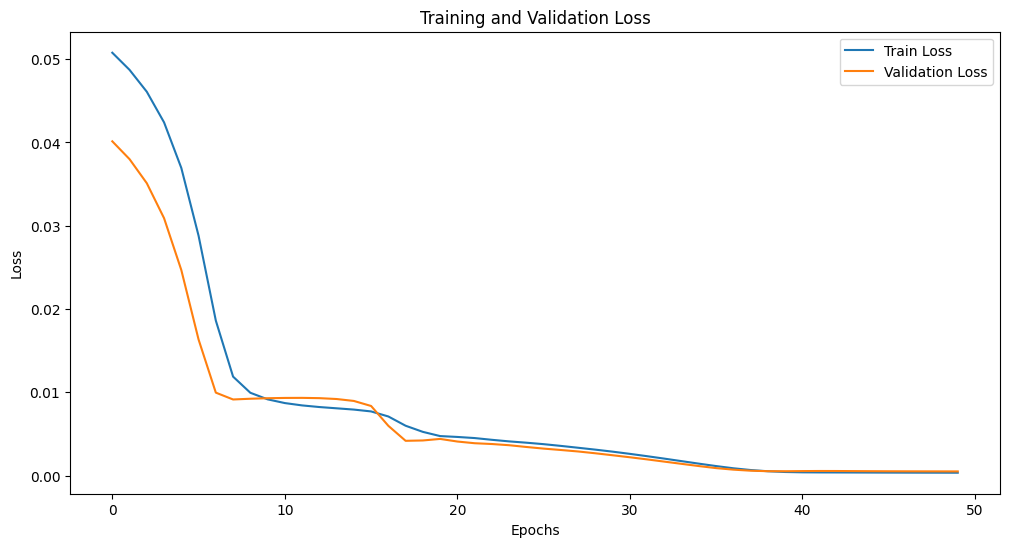

In [181]:
# Plot the training history
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [182]:
# 9. Evaluate: Reconstruction Errors
X_pred = model.predict(X_test)

# Compute reconstruction error
mse = np.mean(np.power(X_test - X_pred, 2), axis=(1,2))
print(f"Shape of MSE: {mse.shape}")

4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 336ms/step
Shape of MSE: (111,)


### Static Threshold

In [183]:
# 10. Set Threshold and Detect Anomalies
threshold = np.percentile(mse, 90)  # Top 10% MSE treated as anomaly

anomalies = mse > threshold

print(f"Anomaly threshold: {threshold}")
print(f"Number of anomalies detected: {np.sum(anomalies)}")
print(f"Anomalies: {mse[anomalies]}")
print(f"Anomalies indices: {np.where(anomalies)[0]}")

Anomaly threshold: 0.01859472469671739
Number of anomalies detected: 11
Anomalies: [0.02162091 0.06498284 0.16921664 0.28112408 0.34823151 0.36529565
 0.28790827 0.17818219 0.12261377 0.06910211 0.02030024]
Anomalies indices: [44 45 46 47 48 49 50 51 52 53 55]


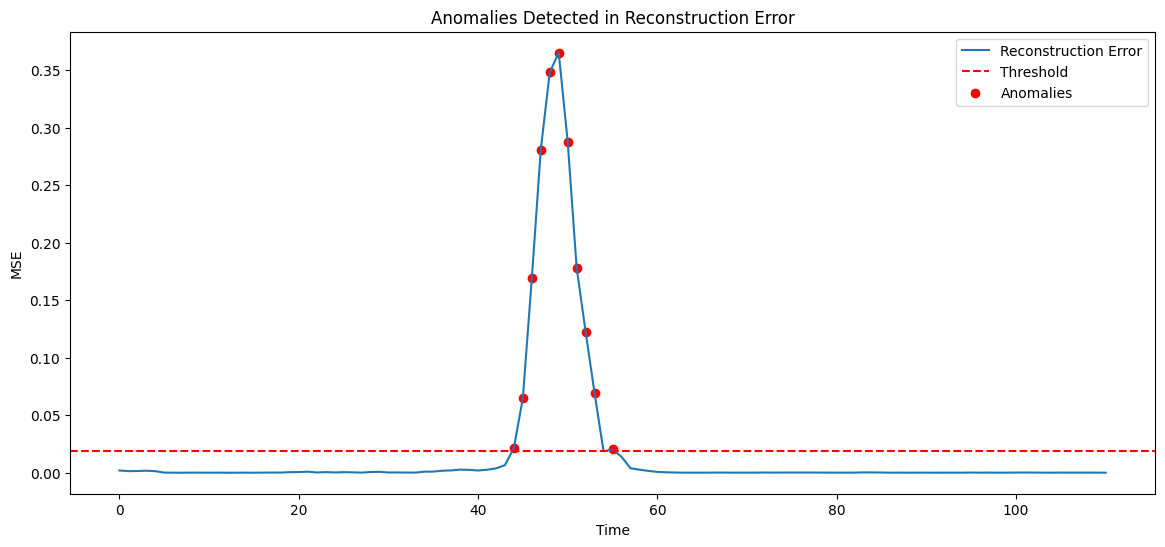

In [184]:
# Plot detected anomalies 
plt.figure(figsize=(14,6))
plt.plot(mse, label='Reconstruction Error')
plt.axhline(y=threshold, color='r', linestyle='--', label='Threshold')
plt.scatter(np.where(anomalies)[0], mse[anomalies], color='red', label='Anomalies')
plt.title('Anomalies Detected in Reconstruction Error')
plt.ylabel('MSE')
plt.xlabel('Time')
plt.legend()
plt.show()

In [185]:
print(X_pred[0])
print(X_pred[1])
print(X_pred[2])
print(X_pred.shape)
print(X_pred[:, 0, 0])

[[0.08293643]
 [0.0692353 ]
 [0.07390782]
 [0.07549106]]
[[0.05284226]
 [0.04654556]
 [0.0475979 ]
 [0.04522804]]
[[0.03173064]
 [0.03296081]
 [0.03156371]
 [0.02781933]]
(111, 4, 1)
[0.08293643 0.05284226 0.03173064 0.02773196 0.04333854 0.07674868
 0.06508157 0.06428187 0.05733869 0.05622732 0.04998736 0.04488837
 0.04916117 0.0487478  0.0480289  0.0426386  0.03913086 0.04108956
 0.04369941 0.05589713 0.06241247 0.07310993 0.10091614 0.1088139
 0.12673807 0.13196273 0.13147387 0.11754654 0.11658674 0.13291106
 0.16055295 0.17408578 0.18152843 0.19000046 0.20094623 0.22149073
 0.23324925 0.24343011 0.24539343 0.24562296 0.24405544 0.24499324
 0.25180948 0.25686646 0.26797816 0.27925095 0.28553686 0.288221
 0.28914133 0.28872642 0.2863825  0.28235176 0.27549627 0.23110452
 0.1415613  0.06226642 0.13973235 0.2185531  0.19104075 0.16490936
 0.13303971 0.10614514 0.09362509 0.07732337 0.06960617 0.06488682
 0.05678087 0.05069491 0.04114118 0.03578182 0.03283864 0.03265372
 0.03427061 0.02

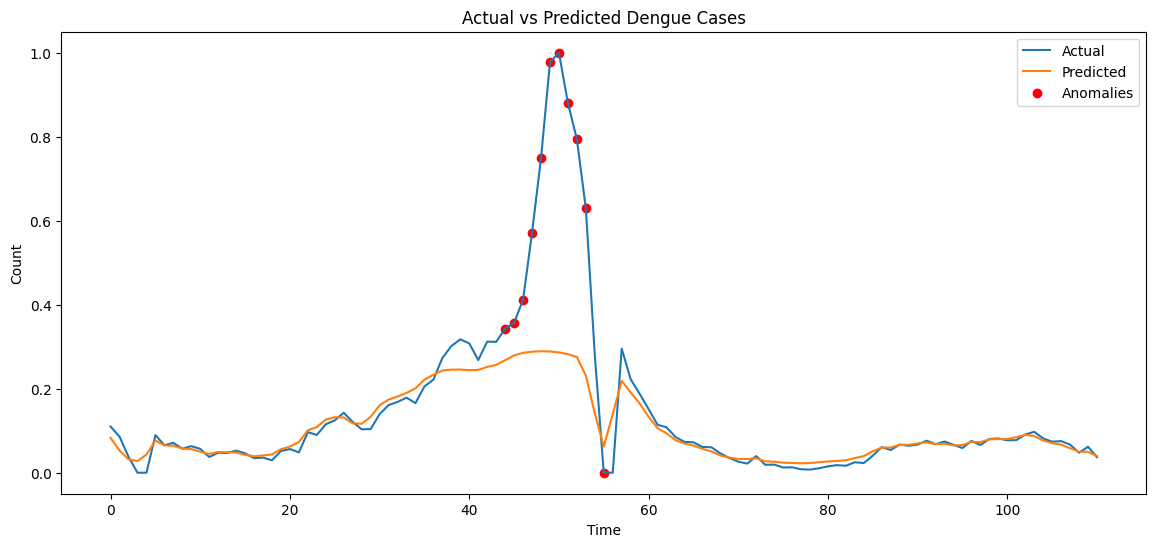

In [186]:
# Plot prediction vs actual AND scatter the anomalies
X_test_first_column = X_test[:, 0, 0]
X_pred_first_column = X_pred[:, 0, 0]

plt.figure(figsize=(14,6))
plt.plot(X_test_first_column, label='Actual')
plt.plot(X_pred_first_column, label='Predicted')
plt.scatter(np.where(anomalies)[0], X_test_first_column[anomalies], color='red', label='Anomalies')
plt.title('Actual vs Predicted Dengue Cases')
plt.ylabel('Count')
plt.xlabel('Time')
plt.legend()
plt.show()

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
All Anomalies Count: 11
All Anomalies: [0.02162091 0.06498284 0.16921664 0.28112408 0.34823151 0.36529565
 0.28790827 0.17818219 0.12261377 0.06910211 0.02030024]
All Anomalies Indices: [144 145 146 147 148 149 150 151 152 153 155]


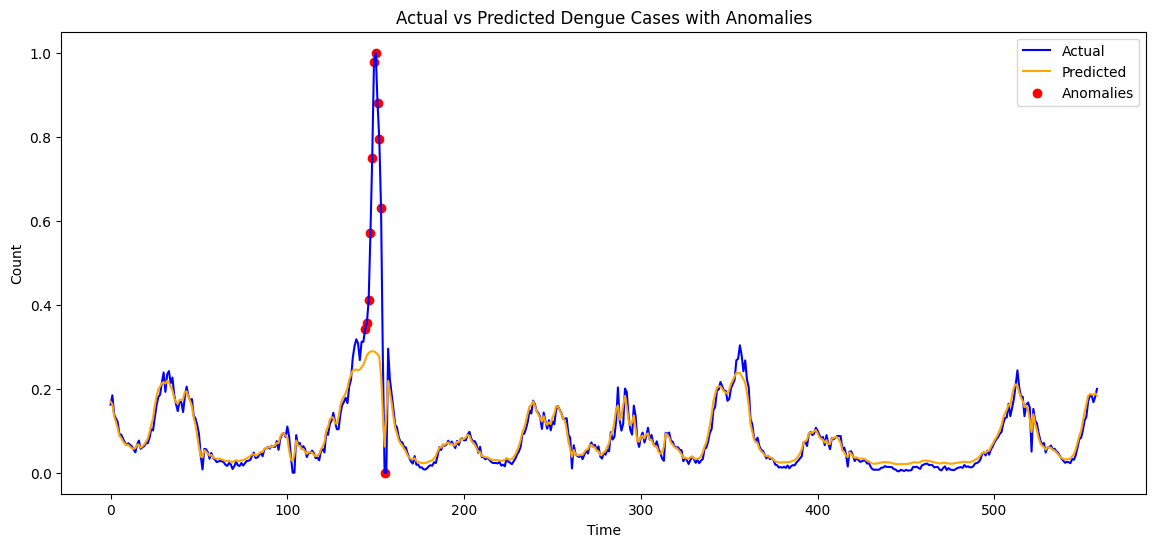

In [187]:
# Plot all prediction vs actual AND scatter the anomalies points 
all_predictions = model.predict(X)

all_mse = np.mean(np.power(X - all_predictions, 2), axis=(1,2))

all_anomalies = all_mse > threshold
print(f"All Anomalies Count: {np.sum(all_anomalies)}")
print(f"All Anomalies: {all_mse[all_anomalies]}")
print(f"All Anomalies Indices: {np.where(all_anomalies)[0]}")

plt.figure(figsize=(14,6))
plt.plot(X[:, 0, 0], label='Actual', color='blue')
plt.plot(all_predictions[:, 0, 0], label='Predicted', color='orange')
plt.scatter(np.where(all_anomalies)[0], X[:, 0, 0][all_anomalies], color='red', label='Anomalies')
plt.title('Actual vs Predicted Dengue Cases with Anomalies')
plt.ylabel('Count')
plt.xlabel('Time')
plt.legend()
plt.show()

### Dynamic Threshold
Instead of static thresholds (like 95th percentile), we'll use a dynamic thresholding method based on the moving average + standard deviation.

This way:
- The threshold can adapt based on local data behavior.
- It handles seasonality and gradual changes better.

#### Plan
- After computing the reconstruction error (MSE) over time,
- We'll apply a moving average + k times standard deviation window.
- If error > (moving average + k×std), we flag it as an anomaly (outbreak).

In [188]:
import scipy.stats

# --- 2. Dynamic Thresholding based on Moving Average
def dynamic_threshold(mse_errors, window_size=10, sigma=3):
    """
    Compute dynamic threshold using moving average and moving std deviation
    Args:
        mse_errors (np.array): Reconstruction errors
        window_size (int): size of moving window
        sigma (float): number of std deviations above mean considered anomaly
    Returns:
        thresholds (np.array): Threshold per point
    """
    thresholds = []
    for i in range(len(mse_errors)):
        if i < window_size:
            window = mse_errors[:i+1]
        else:
            window = mse_errors[i-window_size:i]
        
        mean = np.mean(window)
        std = np.std(window)
        thresholds.append(mean + sigma * std)
    return np.array(thresholds)

In [189]:
# Apply dynamic threshold
window_size = 14

# Higher sigma → fewer, bigger anomalies.
# Lower sigma → more sensitive, more anomalies.
sigma = 3.5

dynamic_thresh = dynamic_threshold(mse, window_size, sigma)


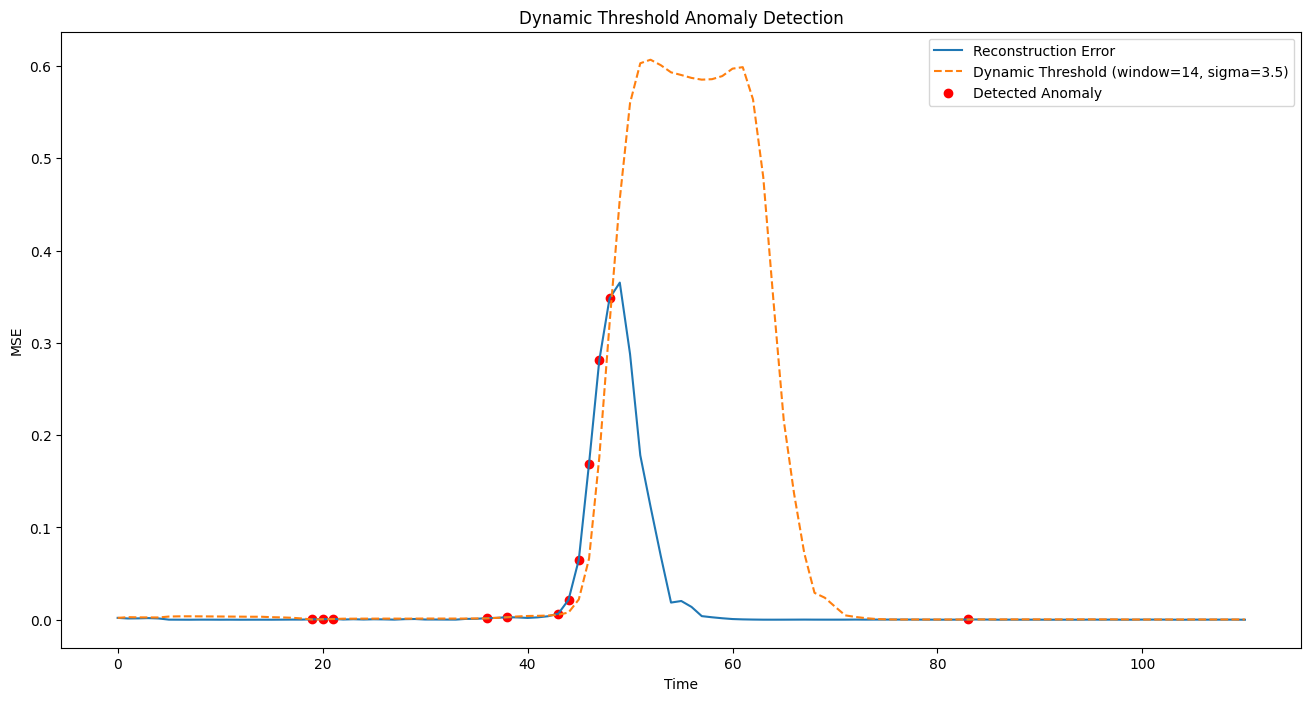

In [190]:
anomalies = mse > dynamic_thresh

# Plotting Results
plt.figure(figsize=(16,8))
plt.plot(mse, label='Reconstruction Error')
plt.plot(dynamic_thresh, label=f'Dynamic Threshold (window={window_size}, sigma={sigma})', linestyle='--')
plt.scatter(np.where(anomalies)[0], mse[anomalies], color='red', label='Detected Anomaly')
plt.legend()
plt.title('Dynamic Threshold Anomaly Detection')
plt.xlabel('Time')
plt.ylabel('MSE')
plt.show()


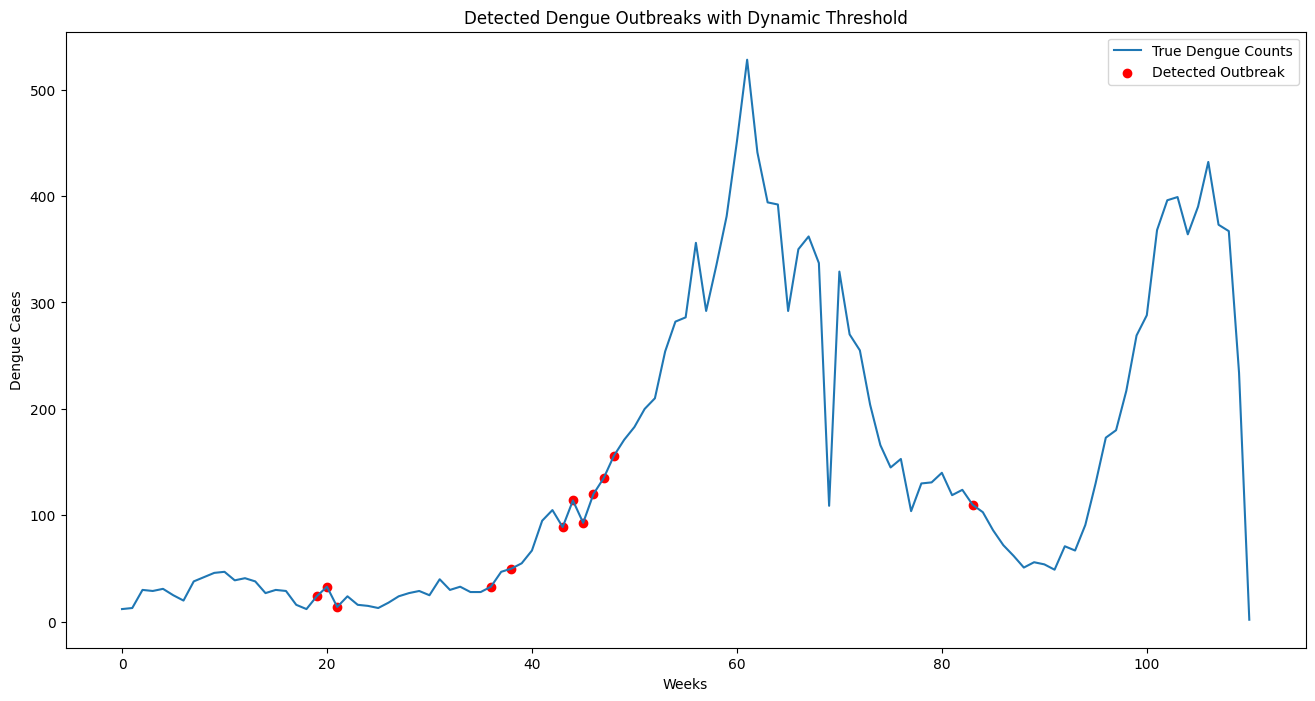

In [191]:
# --- 5. Plot Anomalies on Real Case Counts
plt.figure(figsize=(16,8))
plt.plot(df.iloc[-len(mse):]['Count'].values, label='True Dengue Counts')
plt.scatter(
    np.where(anomalies)[0],
    df.iloc[-len(mse):]['Count'].values[anomalies],
    color='red',
    label='Detected Outbreak'
)
plt.legend()
plt.title('Detected Dengue Outbreaks with Dynamic Threshold')
plt.xlabel('Weeks')
plt.ylabel('Dengue Cases')
plt.show()


### References
Here are the reference to read:
- https://pmc.ncbi.nlm.nih.gov/articles/PMC10452936/ 
- https://github.com/curiousily/Getting-Things-Done-with-Pytorch/blob/master/manuscript/06.time-series-anomaly-ecg.md 

## Load Model

In [4]:
!nvidia-smi

Fri May  2 06:26:49 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 570.124.04             Driver Version: 570.124.04     CUDA Version: 12.8     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA A40                     Off |   00000000:CA:00.0 Off |                    0 |
|  0%   39C    P0             75W /  300W |   43967MiB /  46068MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [6]:
!nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2023 NVIDIA Corporation
Built on Fri_Jan__6_16:45:21_PST_2023
Cuda compilation tools, release 12.0, V12.0.140
Build cuda_12.0.r12.0/compiler.32267302_0


In [9]:
from tensorflow.keras.models import load_model

# Load the model from .h5 file
model = load_model('dengue_outbreak_detection.h5')

2025-05-02 06:44:26.138743: W tensorflow/core/framework/op_kernel.cc:1844] UNKNOWN: JIT compilation failed.


UnknownError: {{function_node __wrapped__Sign_device_/job:localhost/replica:0/task:0/device:GPU:0}} JIT compilation failed. [Op:Sign] name: 